In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten,Dense
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Dataset Completo/DataframeCompleto.csv", index_col = 0)
df = df[['frente','Local de emissão']]

In [4]:
def rotate_image(image, angle):
    (height, width) = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

In [7]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf

# ===========================
# 1. Load Dataset
# ===========================

# Output path for augmented images
output_folder = 'dataset_localemissao_aumentado2'
label_0_folder = os.path.join(output_folder, '0')
label_1_folder = os.path.join(output_folder, '1')

# Create subfolders if they don't exist
os.makedirs(label_0_folder, exist_ok=True)
os.makedirs(label_1_folder, exist_ok=True)

def augment_image(image):
    angles = [-10, -5, -3, 3, 5, 10]
    angle = np.random.choice(angles)
    image = rotate_image(image,angle) 
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

count = 0

for index, row in df.iterrows():
    file_path = row['frente']
    label = int(row['Local de emissão'])  # True/False → 1/0
    
    # Load and preprocess the image
    image = cv.imread(file_path, cv.IMREAD_GRAYSCALE)
    x, y, w, h = 410, 112, 170, 25
    image = image[y:y+h, x:x+w]
    if image is None:
        print(f"⚠️ Failed to load image: {file_path}")
        continue
    
    # Resize and normalize
    #image = cv.resize(image, (224, 224))
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB (needed for tf.image)

    # Select the correct folder based on label
    folder = label_1_folder if label == 1 else label_0_folder

    # Save original image
    original_filename = f"{index}_original.png"
    cv.imwrite(os.path.join(folder, original_filename), image)

    # Generate 6 augmented versions per image
    for i in range(6):
        augmented_image = augment_image(image)
        augmented_image = tf.keras.utils.array_to_img(augmented_image)
        
        # Save augmented image in correct label folder
        filename = f"{index}_aug_{i}.png"
        augmented_image.save(os.path.join(folder, filename))
        
        count += 1

print(f"✅ Generated {count} augmented images.")


✅ Generated 1068 augmented images.


In [8]:
pasta = 'dataset_localemissao_aumentado2'
subpastas = ['0','1']

local_emissao = []

for p in subpastas:
    caminho = os.path.join(pasta, p)
    label = int(p)
    for imagem in os.listdir(caminho):
        imagem_caminho = os.path.join(caminho,imagem)
        img = cv.imread(imagem_caminho,0)
        local_emissao.append({'caminho':imagem_caminho,'imagem':img,'label':label})

df_local = pd.DataFrame(local_emissao)

In [9]:
df_local = df_local[df_local.columns[1:]]

In [10]:
df_local.head()

,imagem,label
0,"[[60, 220, 230, 231, 229, 221, 221, 234, 233, ...",0
1,"[[45, 225, 239, 247, 249, 246, 244, 247, 247, ...",0
2,"[[49, 233, 248, 255, 255, 253, 251, 255, 255, ...",0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


In [15]:
df_sem = df_local[df_local['label'] == 0]
df_com = df_local[df_local['label'] == 1]

df_sem_upsampled = df_sem.sample(len(df_com), replace=True, random_state=42)

df_balanced = pd.concat([df_com, df_sem_upsampled], ignore_index=True)

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total images in balanced DataFrame: {len(df_balanced)}")

Total images in balanced DataFrame: 2268


In [31]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

# First, split into train + validation (85% train, 15% validation)
train_df, val_df = train_test_split(
    df_balanced, 
    test_size=0.2,   # 15% for validation
    random_state=2, 
    stratify=df_balanced['label']
)

# Stack images into a single 4D NumPy array
x_train = np.stack(train_df['imagem'].values)
x_val = np.stack(val_df['imagem'].values)

# Convert labels to numpy arrays
y_train = np.array(train_df['label'])
y_val = np.array(val_df['label'])

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")


Training set size: 1814
Validation set size: 454


In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [33]:
# Adicionar a dimensão do canal
train_dataset = train_dataset.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))
val_dataset = val_dataset.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))

# Normalização
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Criar batches corretamente
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(170, 25, 1)))  # Fewer filters
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))  # Fewer filters
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten Layer
model.add(Flatten())

model.add(Dense(64, activation='relu'))  # Fewer neurons
model.add(Dropout(0.5))  # Dropout to prevent overfitting

model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(0.05)))  # Binary classification

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,       
    restore_best_weights=True
)

C:\Users\maria\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# Treino do modelo
#class_weights = {0: 0.6, 1: 0.4}
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    callbacks = [early_stopping]
)

Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6659 - loss: 0.7147 - val_accuracy: 0.9824 - val_loss: 0.2441
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9641 - loss: 0.2260 - val_accuracy: 0.9978 - val_loss: 0.1002
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9906 - loss: 0.1221 - val_accuracy: 1.0000 - val_loss: 0.0775
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9924 - loss: 0.0945 - val_accuracy: 1.0000 - val_loss: 0.0609
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9965 - loss: 0.0729 - val_accuracy: 1.0000 - val_loss: 0.0510
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9970 - loss: 0.0612 - val_accuracy: 1.0000 - val_loss: 0.0403
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9970 - loss: 0.0502 - val_accuracy: 1.0000 - val_loss: 0.0343
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9976 - loss: 0.0420 - val_accuracy: 1.0000 - v

In [36]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0108
Validation Accuracy: 100.00%


In [1]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

NameError: name 'model' is not defined

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


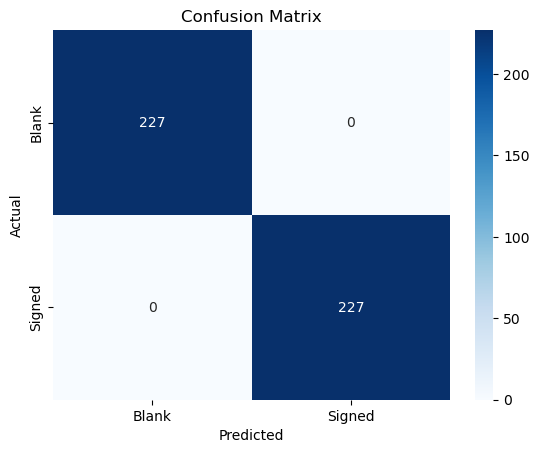

              precision    recall  f1-score   support

       Blank       1.00      1.00      1.00       227
      Signed       1.00      1.00      1.00       227

    accuracy                           1.00       454
   macro avg       1.00      1.00      1.00       454
weighted avg       1.00      1.00      1.00       454



In [45]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (model.predict(x_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Blank', 'Signed'], yticklabels=['Blank', 'Signed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=['Blank', 'Signed']))


In [38]:
model.save("ModeloLocalDeEmissaoNovo3.keras")